# SpamGuard — Message Filtering System

# Standard imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore',category= ConvergenceWarning)

import nltk

In [ ]:
# Download NLTK data (run once)
                     # I make them comment i already download them and have updated data
nltk.download('punkt')            # if you didn't have then uncomment them and run once ,
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# LOAD & EXPLORE DATA

In [ ]:
data_path = "/content/spam.csv"

df = pd.read_csv(data_path)
# head of dataset
print("-----------Head of dataset------------\n")
print(df.head())
print("\n-----------Info of dataset----------\n")
print(df.info())
print("\n-----------Null values------------\n")
print(df.isnull().sum())
print(df.columns)
print('-------------Data Types------------')
print (df.dtypes)

-----------Head of dataset------------

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

-----------Info of dataset----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

-----------Null values------------

Category    0
Message     0
dtype: int64
Index(['Category', 'Message'], dtype='object')
-------------Data Types------------
Category    object
Message     object
dtype: object


# Data Cleaning & Preprocessing

In [ ]:
# Step 3: Data Preprocessing
# Rename columns for convenience
df = df.rename(columns={'Category': 'label', 'Message': 'text'})

# Encode labels: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check distribution
print("Label Distribution:")
print(df['label'].value_counts())
print(f"\nSpam percentage: {(df['label'].value_counts()[1]/len(df))*100:.2f}%")

# Drop duplicates if any
df = df.drop_duplicates()
print(f"\nAfter removing duplicates: {df.shape}")

Label Distribution:
label
0    4825
1     747
Name: count, dtype: int64

Spam percentage: 13.41%

After removing duplicates: (5157, 2)


In [ ]:
# clean the text
def preprocess_text(text):
    # convert the text into lower case letter
    text = text.lower()

    # remove all the special characters and digits
    text = re.sub(r'[^a-zA-Z\s]','',text)

    # reomve extra white space
    text =re.sub(r'\s+',' ',text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back to string
    return ' '.join(tokens)

# Download 'punkt_tab' resource for NLTK (required for word_tokenize)
nltk.download('punkt_tab', quiet=True)

# apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# display samples
print("unclean vs cleaned meassage")
print("Original text sample:", df['text'].iloc[0])
print("\nCleaned text sample:", df['clean_text'].iloc[0])

unclean vs cleaned meassage
Original text sample: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Cleaned text sample: go jurong point crazi avail bugi n great world la e buffet cine got amor wat


In [ ]:
print("Current DataFrame head after preprocessing:")
print(df.head())

print("\nLabel Distribution after preprocessing:")
print(df['label'].value_counts())
print(f"\nSpam percentage: {(df['label'].value_counts()[1]/len(df))*100:.2f}%")

Current DataFrame head after preprocessing:
   label                                               text  \
0      0  Go until jurong point, crazy.. Available only ...   
1      0                      Ok lar... Joking wif u oni...   
2      1  Free entry in 2 a wkly comp to win FA Cup fina...   
3      0  U dun say so early hor... U c already then say...   
4      0  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri wkli comp win fa cup final tkt st m...  
3                u dun say earli hor u c alreadi say  
4          nah dont think goe usf live around though  

Label Distribution after preprocessing:
label
0    4516
1     641
Name: count, dtype: int64

Spam percentage: 12.43%


# Exploratory Data Analysis (EDA)

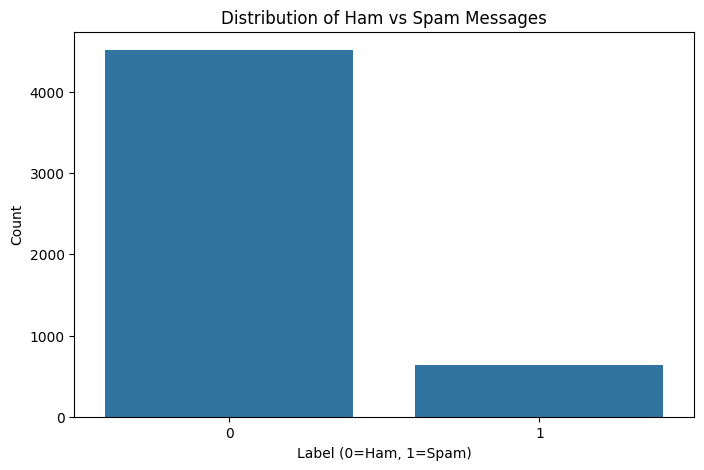

Class distribution:
label
0    4516
1     641
Name: count, dtype: int64

Spam percentage: 12.43%


In [ ]:
# 1. Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham vs Spam Messages')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.show()

print("Class distribution:")
print(df['label'].value_counts())
print(f"\nSpam percentage: {(df['label'].value_counts()[1] / len(df) * 100):.2f}%")

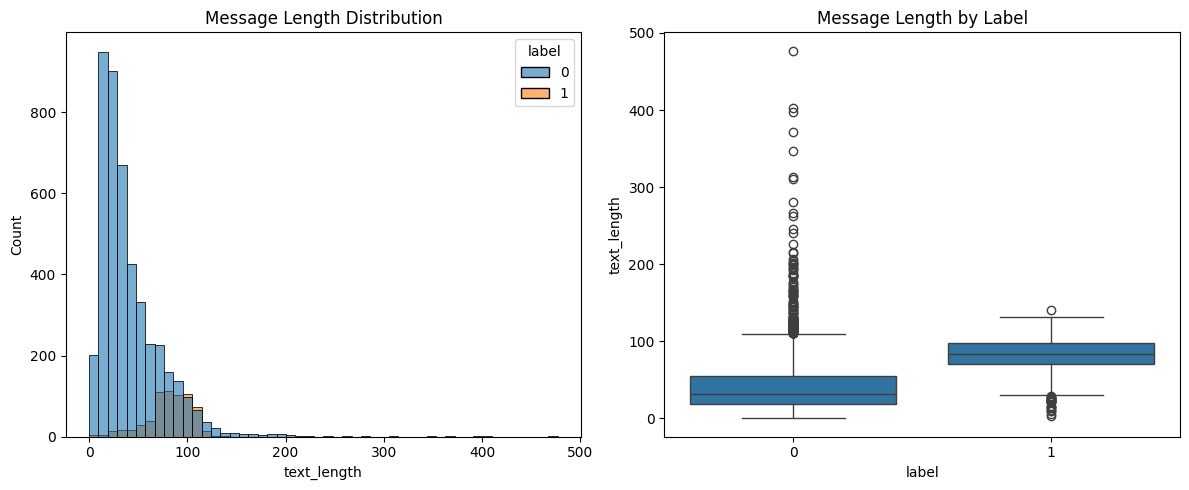

In [ ]:

# 2. Message length analysis
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='text_length', hue='label', bins=50, alpha=0.6)
plt.title('Message Length Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Message Length by Label')

plt.tight_layout()
plt.show()

# Word Cloud Visualization

Word Cloud for Ham Messages:


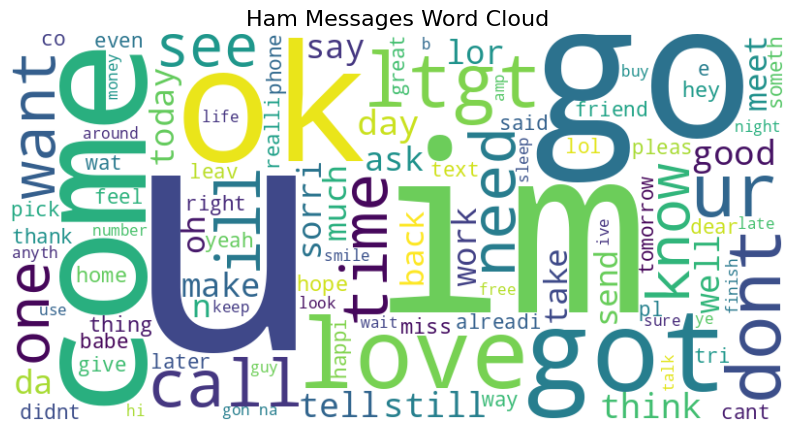


Word Cloud for Spam Messages:


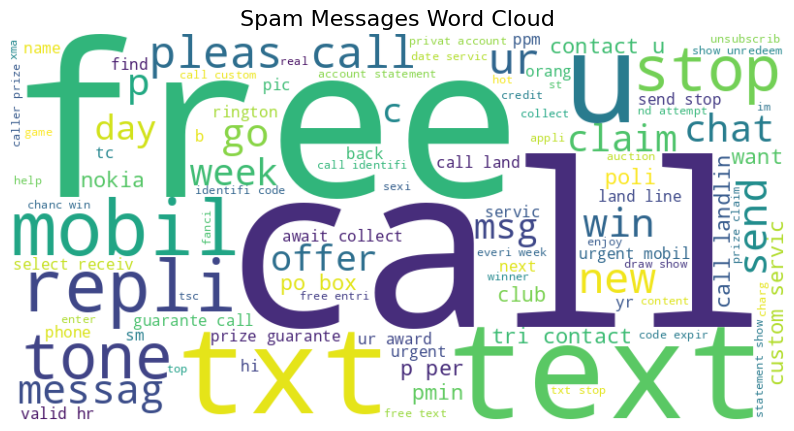

In [ ]:
# Step 6: Word Cloud Visualization
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(' '.join(text_data))

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Generate word clouds for ham and spam
ham_messages = df[df['label'] == 0]['clean_text']
spam_messages = df[df['label'] == 1]['clean_text']

print("Word Cloud for Ham Messages:")
generate_wordcloud(ham_messages, 'Ham Messages Word Cloud')

print("\nWord Cloud for Spam Messages:")
generate_wordcloud(spam_messages, 'Spam Messages Word Cloud')

In [ ]:

# 3. Average length stats
print("\nAverage message length by class:")
print(df.groupby('label')['text_length'].mean())


Average message length by class:
label
0    41.502879
1    81.176287
Name: text_length, dtype: float64


# Feature Extraction (TF-IDF)  & Split data

In [ ]:
# Step 7: Feature Extraction using TF-IDF
# Split data into train and test sets
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Consider unigrams and bigrams
    min_df=5,  # Ignore terms that appear in less than 5 documents
    max_df=0.7  # Ignore terms that appear in more than 70% of documents
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Training shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")

# Check some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample feature names: {feature_names[:20]}")

Training set size: 4125
Test set size: 1032
TF-IDF Training shape: (4125, 1481)
TF-IDF Test shape: (1032, 1481)

Sample feature names: ['abiola' 'abl' 'abt' 'access' 'account' 'account statement' 'across'
 'across sea' 'activ' 'actual' 'ad' 'add' 'address' 'admir' 'admir look'
 'advic' 'affair' 'aft' 'afternoon' 'age']


# Model Training

In [ ]:
# Step 8: Model Training and Evaluation
# Dictionary to store model results
model_results = {}

# 8.1 Naive Bayes
print("Training Naive Bayes Classifier...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("\nNaive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Ham', 'Spam']))

# Store results
model_results['Naive Bayes'] = {
    'model': nb_model,
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'predictions': y_pred_nb
}

# 8.2 Logistic Regression
print("\n" + "="*50)
print("Training Logistic Regression Classifier...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Ham', 'Spam']))

# Store results
model_results['Logistic Regression'] = {
    'model': lr_model,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'predictions': y_pred_lr
}

# 8.3 Support Vector Machine
print("\n" + "="*50)
print("Training Support Vector Machine...")
svm_model = SVC(
    kernel='linear',
    random_state=42,
    class_weight='balanced'
)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("\nSVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Ham', 'Spam']))

# Store results
model_results['SVM'] = {
    'model': svm_model,
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'predictions': y_pred_svm
}

Training Naive Bayes Classifier...

Naive Bayes Results:
Accuracy: 0.9728682170542635

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       904
        Spam       0.96      0.81      0.88       128

    accuracy                           0.97      1032
   macro avg       0.97      0.90      0.93      1032
weighted avg       0.97      0.97      0.97      1032


Training Logistic Regression Classifier...

Logistic Regression Results:
Accuracy: 0.9670542635658915

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       904
        Spam       0.85      0.89      0.87       128

    accuracy                           0.97      1032
   macro avg       0.92      0.93      0.93      1032
weighted avg       0.97      0.97      0.97      1032


Training Support Vector Machine...

SVM Results:
Accuracy: 0.9689922480620154

Classification Report:
      

# Model Comparison

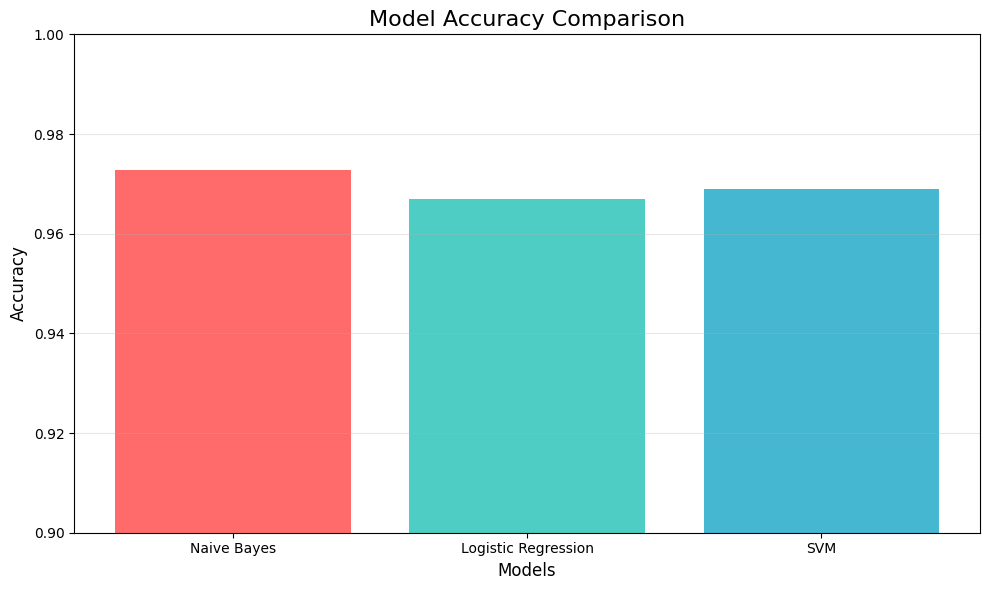


Best Model: Naive Bayes with accuracy: 0.9729


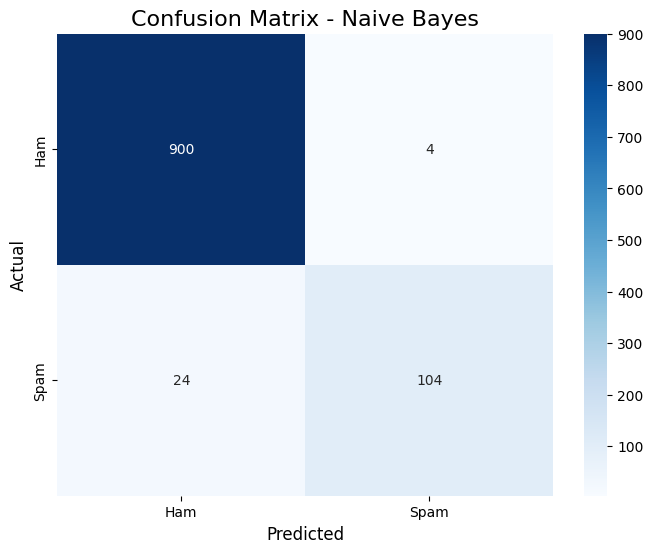

In [ ]:
# Step 9: Model Comparison and Visualization
# 9.1 Compare model accuracies
model_names = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color= ['#FF6B6B','#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.9, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 9.2 Confusion Matrix for the best model
best_model_name = max(model_results, key=lambda x: model_results[x]['accuracy'])
print(f"\nBest Model: {best_model_name} with accuracy: {model_results[best_model_name]['accuracy']:.4f}")

# Create confusion matrix
best_predictions = model_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()
best_model = model_results[best_model_name]['model']

# Make Predictions on New Messages

In [ ]:
def predict_spam(model, message):
    """
    Predict if a new message is spam or ham
    """
    # Preprocess the message
    cleaned_message = preprocess_text(message)


    # Transform using the same TF-IDF vectorizer
    message_tfidf = tfidf_vectorizer.transform([cleaned_message]).toarray()

    # Make prediction
    prediction = model.predict(message_tfidf)[0]
    probability = model.predict_proba(message_tfidf)[0]

    # Return result
    label = "SPAM" if prediction == 1 else "HAM"
    confidence = probability[prediction] * 100

    return label, confidence, probability

# Test with sample messages
test_messages = [
    "Congratulations! You've won a free iPhone. Click here to claim.",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account has been compromised. Reply with your password.",
    "Can you pick up milk on your way home?",
    "You are selected for a £1000 prize! Call now to claim."
]

print("Testing model predictions:")
print("-" * 60)
for msg in test_messages:
    label, confidence, probs = predict_spam(lr_model, msg)
    print(f"Message: {msg[:50]}...")
    print(f"Prediction: {label} (Confidence: {confidence:.2f}%)")

Testing model predictions:
------------------------------------------------------------
Message: Congratulations! You've won a free iPhone. Click h...
Prediction: SPAM (Confidence: 86.65%)
Message: Hey, are we still meeting for lunch tomorrow?...
Prediction: HAM (Confidence: 96.92%)
Message: URGENT: Your bank account has been compromised. Re...
Prediction: SPAM (Confidence: 85.13%)
Message: Can you pick up milk on your way home?...
Prediction: HAM (Confidence: 96.42%)
Message: You are selected for a £1000 prize! Call now to cl...
Prediction: SPAM (Confidence: 94.84%)


# Testing the Model Performance

In [ ]:
# Step 13: Create a Prediction Function
def predict_message(message):
    """
    Predict if a message is spam or ham
    """
    # Use current model if files not found
    model = best_model
    vectorizer = tfidf_vectorizer

    # Preprocess the message
    cleaned_message = preprocess_text(message)

    # Transform using TF-IDF
    message_tfidf = vectorizer.transform([cleaned_message])

    # Make prediction
    prediction = model.predict(message_tfidf)[0]
    probability = model.predict_proba(message_tfidf)[0]

    # Return result
    result = {
        'message': message,
        'cleaned_message': cleaned_message,
        'prediction': 'SPAM' if prediction == 1 else 'HAM',
        'spam_probability': probability[1] if len(probability) > 1 else None,
        'ham_probability': probability[0]
    }

    return result

# Test the prediction function
test_messages = [
    "Congratulations! You've won a free iPhone. Click here to claim your prize!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account has been compromised. Call now to secure it.",
    "Can you pick up some milk on your way home?"
]

print("Testing Prediction Function:\n")
for msg in test_messages:
    result = predict_message(msg)
    print(f"Message: {msg[:50]}...")
    print(f"Prediction: {result['prediction']}")
    print(f"Spam Probability: {result['spam_probability']:.4f}")
    print(f"Ham Probability: {result['ham_probability']:.4f}")
    print("-" * 50)

Testing Prediction Function:

Message: Congratulations! You've won a free iPhone. Click h...
Prediction: SPAM
Spam Probability: 0.9645
Ham Probability: 0.0355
--------------------------------------------------
Message: Hey, are we still meeting for lunch tomorrow?...
Prediction: HAM
Spam Probability: 0.0045
Ham Probability: 0.9955
--------------------------------------------------
Message: URGENT: Your bank account has been compromised. Ca...
Prediction: SPAM
Spam Probability: 0.5824
Ham Probability: 0.4176
--------------------------------------------------
Message: Can you pick up some milk on your way home?...
Prediction: HAM
Spam Probability: 0.0060
Ham Probability: 0.9940
--------------------------------------------------


In [ ]:
# Step 14: Additional Analysis - Error Analysis
print("Error Analysis - Misclassified Samples:")

# Get misclassified samples from the best model
best_predictions = model_results[best_model_name]['predictions']
misclassified_indices = np.where(y_test.values != best_predictions)[0]

if len(misclassified_indices) > 0:
    print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

    # Display some misclassified examples
    for i in misclassified_indices[:5]:  # Show first 5
        print(f"\nIndex: {i}")
        print(f"Actual: {'SPAM' if y_test.iloc[i] == 1 else 'HAM'}")
        print(f"Predicted: {'SPAM' if best_predictions[i] == 1 else 'HAM'}")
        print(f"Message: {X_test.iloc[i][:100]}...")
        print("-" * 50)
else:
    print("No misclassified samples found!")

Error Analysis - Misclassified Samples:

Total misclassified samples: 28

Index: 86
Actual: HAM
Predicted: SPAM
Message: sir wait call free pleas call...
--------------------------------------------------

Index: 107
Actual: SPAM
Predicted: HAM
Message: free game get rayman golf free game arcad st get ur game set repli post save activ press key arcad t...
--------------------------------------------------

Index: 114
Actual: SPAM
Predicted: HAM
Message: u get phone wan na chat set meet call u cum moro luv jane xx callsminmoremobsemspoboxpowa...
--------------------------------------------------

Index: 217
Actual: SPAM
Predicted: HAM
Message: oh god ive found number im glad text back xafter msg cst std ntwk chg...
--------------------------------------------------

Index: 247
Actual: SPAM
Predicted: HAM
Message: miss call alert number call left messag...
--------------------------------------------------


In [ ]:
# Step 15: Summary and Final Metrics
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

print("\nDataset Statistics:")
print(f"Total Messages: {len(df)}")
print(f"Ham Messages: {len(df[df['label']==0])} ({(len(df[df['label']==0])/len(df))*100:.1f}%)")
print(f"Spam Messages: {len(df[df['label']==1])} ({(len(df[df['label']==1])/len(df))*100:.1f}%)")

print("\nModel Performance:")
for model_name in model_names:
    acc = model_results[model_name]['accuracy']
    print(f"{model_name}: {acc:.4f}")

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {model_results[best_model_name]['accuracy']:.4f}")

# Calculate precision and recall for the best model
y_pred_best = model_results[best_model_name]['predictions']
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"\nBest Model Detailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\n" + "="*60)
print("SPAM DETECTION SYSTEM - IMPLEMENTATION COMPLETE")
print("="*60)

FINAL MODEL PERFORMANCE SUMMARY

Dataset Statistics:
Total Messages: 5157
Ham Messages: 4516 (87.6%)
Spam Messages: 641 (12.4%)

Model Performance:
Naive Bayes: 0.9729
Logistic Regression: 0.9671
SVM: 0.9690

Best Model: Naive Bayes
Best Accuracy: 0.9729

Best Model Detailed Metrics:
Precision: 0.9630
Recall: 0.8125
F1-Score: 0.8814

SPAM DETECTION SYSTEM - IMPLEMENTATION COMPLETE


In [ ]:
model_names_list = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracies_list = [nb_accuracy, lr_accuracy, svm_accuracy]

best_model_accuracy = max(accuracies_list)
best_model_index = accuracies_list.index(best_model_accuracy)
best_model_name_for_plot = model_names_list[best_model_index]

# Create a DataFrame for easier plotting and to identify the best model
plot_df = pd.DataFrame({
    'Model': model_names_list,
    'Accuracy': accuracies_list
})

# Add a column to highlight the best model
plot_df['Highlight'] = plot_df['Model'] == best_model_name_for_plot

print("Data prepared for plotting:")
print(plot_df)

Data prepared for plotting:
                 Model  Accuracy  Highlight
0          Naive Bayes  0.972868       True
1  Logistic Regression  0.967054      False
2                  SVM  0.968992      False


# Task
Create model artifacts `model_artifacts/naive_bayes_model.joblib` and `model_artifacts/tfidf_vectorizer.joblib` by saving the trained `nb_model` and `tfidf_vectorizer` respectively.

## model_artifacts/naive_bayes_model.joblib

### Subtask:
Store the trained Naive Bayes model for prediction by saving the `nb_model` to `model_artifacts/naive_bayes_model.joblib`.


**Reasoning**:
To save the `nb_model`, I need to import the `joblib` library, create the `model_artifacts` directory if it doesn't exist, and then use `joblib.dump` to save the model object to the specified file path.



In [ ]:
import joblib
import os

# Create the model_artifacts directory if it doesn't exist
model_artifacts_dir = 'model_artifacts'
os.makedirs(model_artifacts_dir, exist_ok=True)

# Save the nb_model using joblib
model_path = os.path.join(model_artifacts_dir, 'naive_bayes_model.joblib')
joblib.dump(nb_model, model_path)

print(f"Naive Bayes model saved to {model_path}")

Naive Bayes model saved to model_artifacts/naive_bayes_model.joblib


## model_artifacts/tfidf_vectorizer.joblib

### Subtask:
Store the trained TF-IDF vectorizer by saving the `tfidf_vectorizer` to `model_artifacts/tfidf_vectorizer.joblib`.

**Reasoning**:
To save the `tfidf_vectorizer`, I will use the `joblib` library to dump the object to the specified file path within the `model_artifacts` directory.



In [ ]:
import joblib
import os

# The model_artifacts directory should already exist from the previous step
model_artifacts_dir = 'model_artifacts'

# Save the tfidf_vectorizer using joblib
vectorizer_path = os.path.join(model_artifacts_dir, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf_vectorizer, vectorizer_path)

print(f"TF-IDF vectorizer saved to {vectorizer_path}")

TF-IDF vectorizer saved to model_artifacts/tfidf_vectorizer.joblib
